<a href="https://colab.research.google.com/github/ryu-0729/ml-python/blob/master/ml-python/chapter3/malticlass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 多クラス分類器
- じゃんけん画像の判定

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


### 学習、検証データの取得

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/rps.zip \
    -O /tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

--2023-03-26 09:24:24--  https://storage.googleapis.com/learning-datasets/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 173.194.218.128, 108.177.11.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M   139MB/s    in 1.4s    

2023-03-26 09:24:26 (139 MB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]

--2023-03-26 09:24:26--  https://storage.googleapis.com/learning-datasets/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 173.194.218.128, 108.177.11.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘/tmp/rps-test-set.zip’

/tmp/rps-tes

In [3]:
import os
import zipfile


local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

local_zip = '/tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [4]:
rock_dir = os.path.join('/tmp/rps/rock')
paper_dir = os.path.join('/tmp/rps/paper')
scissors_dir = os.path.join('/tmp/rps/scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
print(rock_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock05ck01-011.png', 'rock04-002.png', 'rock04-025.png', 'rock06ck02-037.png', 'rock02-078.png', 'rock07-k03-052.png', 'rock04-030.png', 'rock01-064.png', 'rock03-076.png', 'rock05ck01-038.png']
['paper03-044.png', 'paper03-002.png', 'paper07-040.png', 'paper03-036.png', 'paper01-060.png', 'paper07-098.png', 'paper05-027.png', 'paper05-112.png', 'paper06-078.png', 'paper07-074.png']
['scissors01-102.png', 'scissors01-033.png', 'scissors01-119.png', 'scissors01-082.png', 'scissors04-043.png', 'scissors01-052.png', 'testscissors03-013.png', 'testscissors02-053.png', 'scissors03-008.png', 'scissors01-034.png']


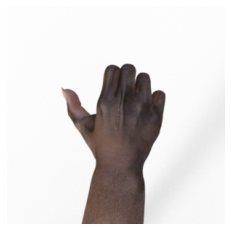

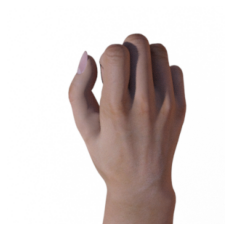

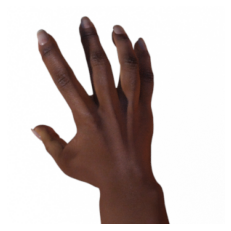

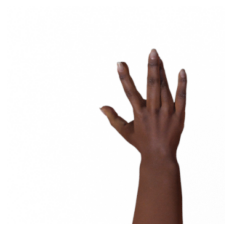

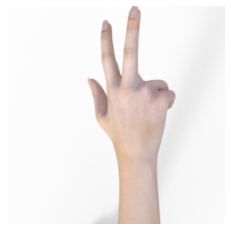

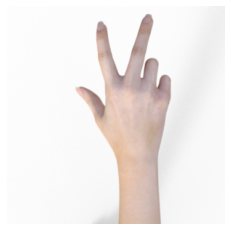

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_rock = [os.path.join(rock_dir, fname) 
                for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) 
                for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) 
                for fname in scissors_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

### モデルの構築

In [7]:
import tensorflow as tf
import keras.preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


TRAINING_DIR = '/tmp/rps/'
training_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

VALIDATION_DIR = '/tmp/rps-test-set/'
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150, 150),
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150, 150),
    class_mode='categorical'
)

model = tf.keras.models.Sequential([
    # input_shapeは目的の画像サイズと一致していることに注意。150 * 150 3バイトカラー
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # DNNに入力するために、フラット化する
    tf.keras.layers.Flatten(),
    # ドロップアウト正規化
    tf.keras.layers.Dropout(0.5),
    # 512ニューロンを持つ隠れ層
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax'),
])

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 17, 17, 128)     

### モデルをコンパイル

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### 学習

In [10]:
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    verbose='1'
)

Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25


### モデルの検証

In [11]:
import numpy as np
from google.colab import files
from keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():
  # predicting images
  path = fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)


Saving 1266022.jpg to 1266022.jpg
Saving img_eac052de9de21ccad3bee3451f61fa4b786879.webp to img_eac052de9de21ccad3bee3451f61fa4b786879.webp
1/1 [==============================] - 0s 245ms/step
1266022.jpg
[[0. 1. 0.]]
1/1 [==============================] - 0s 20ms/step
img_eac052de9de21ccad3bee3451f61fa4b786879.webp
[[1. 0. 0.]]
